This IPYNB contains cells that process form feedback data.

Author: Vamsy Malladi

# Import Statements

In [1]:
import sys
import pandas as pd
import numpy as np
import scipy as sp
import os
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from nltk.corpus import wordnet
from translate import Translator
from matplotlib.lines import Line2D
translator = Translator(from_lang="german", to_lang="english")
if os.path.isdir("Plots/") == False:
    os.mkdir("Plots/")
demo_directory_path = "Plots/Demographics_plots/"
if os.path.isdir(demo_directory_path) == False:
    os.mkdir(demo_directory_path)
sam_directory_path = "Plots/SAM_plots/"
if os.path.isdir(sam_directory_path) == False:
    os.mkdir(sam_directory_path)
post_study_directory_path = "Plots/Post_Study_forms_plots/"
if os.path.isdir(post_study_directory_path) == False:
    os.mkdir(post_study_directory_path)



# Reading all the excel docs into list of data frames

In [107]:
df_list = list()
file_names = glob.glob("Google_forms_responses/*.xlsx")
for file_name in file_names:
    df_list.append(pd.read_excel(file_name, 
                   usecols=lambda x: x not in ["Timestamp"], 
                   dtype={'Teilnehmer ID / Participant’s ID': np.str}))
    print(file_name)


Google_forms_responses\Demographics form (Responses).xlsx
Google_forms_responses\Post Study VR (Responses).xlsx
Google_forms_responses\Post Study VR + Haptics (Responses).xlsx
Google_forms_responses\Questionnaire 1 (Responses).xlsx
Google_forms_responses\Questionnaire 2 (Responses).xlsx
Google_forms_responses\Questionnaire 3 (Responses).xlsx


<ipython-input-107-1e212d5b9a29>:6: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype={'Teilnehmer ID / Participant’s ID': np.str}))


# Splitting the dataframes by phases
1 - 6 participants belong to SSST validation phase <br/>
7 - 14 participants belong to phase 1 <br/>
15 - 22 participants belong to phase 2 <br/>
23 - 30 participants belong to phase 3 <br/>

In [108]:
# Cleaning the participant ID column. Add a column "Phase" to the data frames that indicates the phase.
# Renaming columns of each form/dataframe for convenience

for i, df in enumerate(df_list):
    df['Teilnehmer ID / Participant’s ID'].replace(["ID01"], '01', inplace=True)
    df['Teilnehmer ID / Participant’s ID'] = df['Teilnehmer ID / Participant’s ID'].str.lstrip('0')
    df['Teilnehmer ID / Participant’s ID'] = df['Teilnehmer ID / Participant’s ID'].astype(str).astype(int)
    df['Phase'] = np.select([(df['Teilnehmer ID / Participant’s ID'] <= 6), 
                            (df['Teilnehmer ID / Participant’s ID'] > 6) & (
                                df['Teilnehmer ID / Participant’s ID'] <= 14) | (df['Teilnehmer ID / Participant’s ID'] == 31) | (df['Teilnehmer ID / Participant’s ID'] == 32),
                            (df['Teilnehmer ID / Participant’s ID'] > 14) & (
                                df['Teilnehmer ID / Participant’s ID'] <= 22) | (df['Teilnehmer ID / Participant’s ID'] == 33),
                            (df['Teilnehmer ID / Participant’s ID'] > 22) & (
                                df['Teilnehmer ID / Participant’s ID'] <= 30) | (df['Teilnehmer ID / Participant’s ID'] == 34) | (
                                    df['Teilnehmer ID / Participant’s ID'] == 35) | (df['Teilnehmer ID / Participant’s ID'] == 36)],
                            ["SSST", "1", "2", "3"])
    if i >= 3:
        df.columns = ['ID', 'Arousal_rating', 'Pleasure_rating', 'Phase']
    elif i == 0:
        df.columns = ['ID', 'Age', 'Gender', 'Occupation', 'VR_Ownership', 'VR_usage_freq', 
                      'Haptics_exp', 'Computer_literacy', 'Programming_exp', 'VR_exp', 
                      'Occupation_stress', 'Relaxation_actions', 'Games_annual', 'Games', 'Games_week_hrs', 'Phase']
    elif i == 1:
        df.drop(columns = ['Scale for reference'], inplace=True)
        df.columns = ['ID', 'Involving', 'Relaxing', 'Recommendation', 'Rewarding', 'Fun', 'Relaxing_in_future', 
                      'Frustrating', 'Tiring', 'VR_Aesthetically_Pleasing', 'Phase']
    else: 
        df.drop(columns=['Scale for reference'], inplace=True)
        df.columns = ['ID', 'Involving', 'Relaxing', 'Recommendation', 'Rewarding', 'Fun',
                      'Relaxing_in_future', 'Frustrating', 'Tiring', 'VR_Aesthetically_Pleasing',
                      'Haptic_soothing', 'Haptic_distracting', 'Haptic_linking_VR', 'Phase']
    df.drop(df[df['ID'].isin([4, 5, 10, 12, 20, 24, 26, 27])].index, inplace=True)

    


# Processing demographics questionnaire

Mean age of participants per group/phase
Phase
1       24.625
2       24.375
3       25.125
SSST    26.250
Name: Age, dtype: float64

Standard deviation of age of participants per group/phase
Phase
1       4.340425
2       1.505941
3       2.587746
SSST    4.031129
Name: Age, dtype: float64


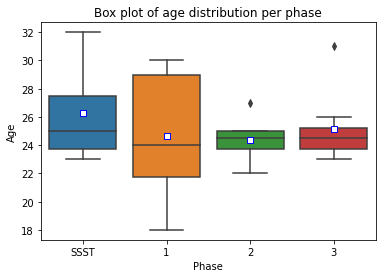

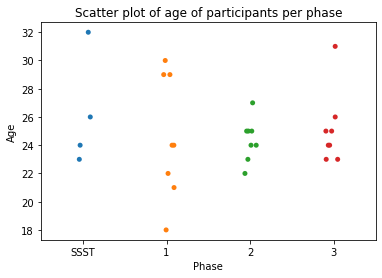

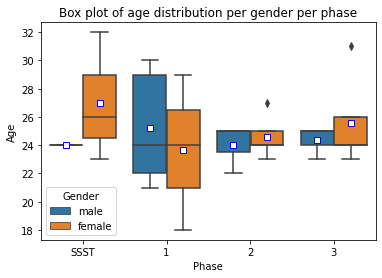


Mean age of participants per gender per group/phase
Phase  Gender
1      female    23.666667
       male      25.200000
2      female    24.600000
       male      24.000000
3      female    25.600000
       male      24.333333
SSST   female    27.000000
       male      24.000000
Name: Age, dtype: float64

Gender distribution of participants per group/phase
Phase  Gender
1      male      5
       female    3
2      female    5
       male      3
3      female    5
       male      3
SSST   female    3
       male      1
Name: Gender, dtype: int64


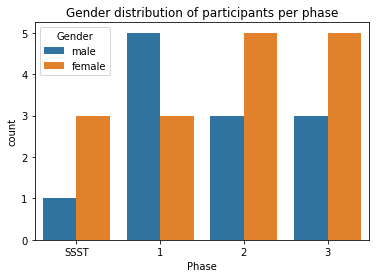

In [109]:
df = df_list[0]

df['Gender'] = df['Gender'].str.lower().str.strip()
df['Gender'] = df['Gender'].map({'männlich': 'male', 'm': 'male', 'maennlich': 'male', 'frau': 'female',
                                'weiblich': 'female', 'female': 'female', 'male': 'male'})
df_grouped = df.groupby(['Phase'])

# Finding mean age per phase and gender distribution amongst phases.

print("Mean age of participants per group/phase")
print(df_grouped['Age'].mean())

print("\nStandard deviation of age of participants per group/phase") 
print(df_grouped['Age'].std())

sns_plot = sns.boxplot(x=df['Phase'], 
                       y=df['Age'], 
                       showmeans=True,
                       meanprops={"marker": "s", "markerfacecolor": "white", "markeredgecolor": "blue"}).set_title('Box plot of age distribution per phase')
plt.show()
fig = sns_plot.get_figure()
fig.savefig(demo_directory_path + "Box_plot_age_distribution_per_phase.png")

sns_plot = sns.stripplot(x=df['Phase'], y=df['Age']).set_title("Scatter plot of age of participants per phase")
plt.show()
fig = sns_plot.get_figure()
fig.savefig(demo_directory_path + "Scatter_plot_age_distribution_per_phase.png")

# sns.displot(x=df['Age'], hue=df['Phase'], kind="kde")
# plt.show()

sns_plot = sns.boxplot(x=df['Phase'], y=df['Age'], hue=df['Gender'], showmeans=True,
            meanprops={"marker": "s", "markerfacecolor": "white", "markeredgecolor": "blue"}).set_title("Box plot of age distribution per gender per phase")
plt.show()
fig = sns_plot.get_figure()
fig.savefig(demo_directory_path +
            "Box_plot_age_distribution_per_gender_per_phase.png")

print("\nMean age of participants per gender per group/phase")
print(df.groupby(['Phase', 'Gender'])['Age'].mean())

print("\nGender distribution of participants per group/phase")
print(df_grouped['Gender'].value_counts())

sns_plot = sns.countplot(x= df['Phase'], hue=df['Gender']).set_title("Gender distribution of participants per phase")
plt.show()
fig = sns_plot.get_figure()
fig.savefig(demo_directory_path +
            "Gender_distribution_per_phase.png")



VR ownership distribution per group/phase
Phase  VR_Ownership
1      Nein/No         8
2      Nein/No         8
3      Nein/No         8
SSST   Nein/No         4
Name: VR_Ownership, dtype: int64


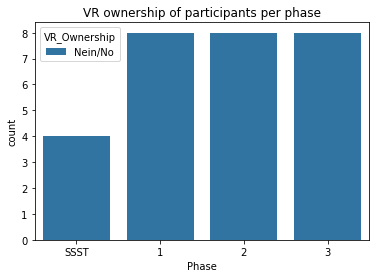


VR usage frequency per group/phase
Phase  VR_usage_freq                                        
1      Nie / Never                                              5
       Mehrmals /einmal pro Jahr / once / few times a year      3
2      Nie / Never                                              7
       Mehrmals /einmal pro Jahr / once / few times a year      1
3      Nie / Never                                              6
       Mehrmals /einmal pro Jahr / once / few times a year      2
SSST   Mehrmals /einmal pro Jahr / once / few times a year      3
       Mehrmals /einmal pro Monat / once / few times a month    1
Name: VR_usage_freq, dtype: int64


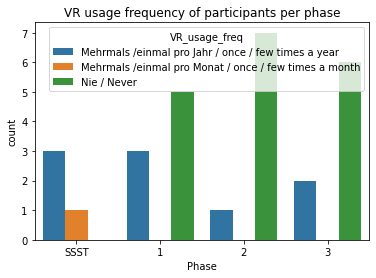


Haptics prior experience per group/phase
Phase  Haptics_exp
1      Ja/Yes         4
       Nein/No        4
2      Ja/Yes         4
       Nein/No        4
3      Nein/No        7
       Ja/Yes         1
SSST   Ja/Yes         3
       Nein/No        1
Name: Haptics_exp, dtype: int64


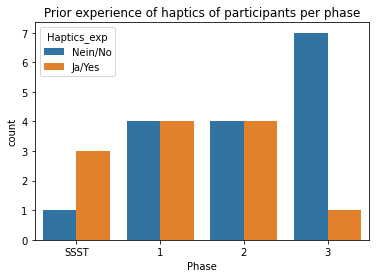

In [110]:
# Finding out VR ownership stats, VR usage frequency stats and experience with haptics. 

print("\nVR ownership distribution per group/phase")
print(df_grouped['VR_Ownership'].value_counts())

sns_plot = sns.countplot(x= df['Phase'], hue=df['VR_Ownership']).set_title("VR ownership of participants per phase")
plt.show()
fig = sns_plot.get_figure()
fig.savefig(demo_directory_path +
            "VR_Ownership_per_phase.png")


print("\nVR usage frequency per group/phase")
print(df_grouped['VR_usage_freq'].value_counts())

sns_plot = sns.countplot(x=df['Phase'], hue=df['VR_usage_freq']).set_title(
    "VR usage frequency of participants per phase")
plt.show()
fig = sns_plot.get_figure()
fig.savefig(demo_directory_path +
            "VR_Usage_freq_per_phase.png")


print("\nHaptics prior experience per group/phase")
print(df_grouped['Haptics_exp'].value_counts())

sns_plot = sns.countplot(x=df['Phase'], hue=df['Haptics_exp']).set_title(
    "Prior experience of haptics of participants per phase")
plt.show()
fig = sns_plot.get_figure()
fig.savefig(demo_directory_path +
            "Haptics_prior_exp_per_phase.png")


Mean Computer Literacy of participants per group/phase
Phase
1       5.000
2       4.375
3       4.750
SSST    5.250
Name: Computer_literacy, dtype: float64

Median Computer Literacy of participants per group/phase
Phase
1       5.0
2       4.5
3       5.0
SSST    5.5
Name: Computer_literacy, dtype: float64


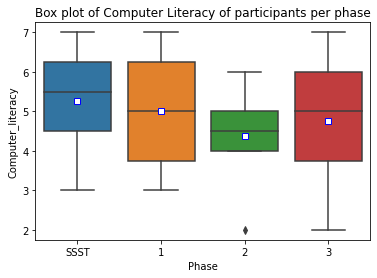


Computer Literacy value_counts per group/phase
Phase  Computer_literacy
1      3                    2
       5                    2
       7                    2
       4                    1
       6                    1
2      4                    3
       5                    3
       2                    1
       6                    1
3      6                    3
       4                    2
       2                    1
       3                    1
       7                    1
SSST   3                    1
       5                    1
       6                    1
       7                    1
Name: Computer_literacy, dtype: int64


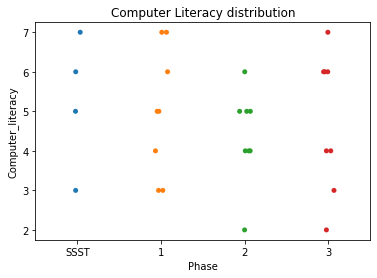

Mean programming experience of participants per group/phase
Phase
1       3.125
2       2.625
3       2.875
SSST    3.500
Name: Programming_exp, dtype: float64

Median programming experience of participants per group/phase
Phase
1       3.0
2       2.0
3       2.0
SSST    3.5
Name: Programming_exp, dtype: float64


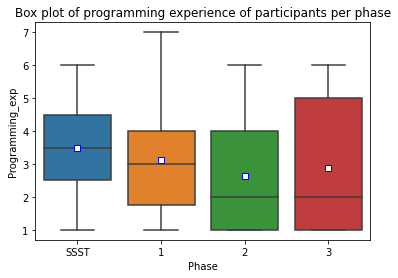


Programming experience value_counts per group/phase
Phase  Programming_exp
1      1                  2
       3                  2
       4                  2
       2                  1
       7                  1
2      1                  4
       4                  2
       3                  1
       6                  1
3      1                  3
       2                  2
       5                  2
       6                  1
SSST   1                  1
       3                  1
       4                  1
       6                  1
Name: Programming_exp, dtype: int64


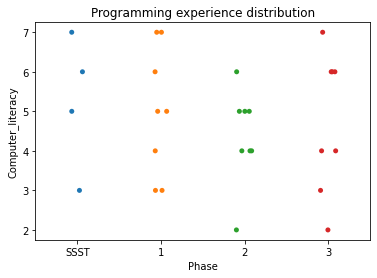

In [111]:
# 1 - 7 scale questions ('Computer_literacy', 'Programming_exp') analysis

# Computer Literacy

print("Mean Computer Literacy of participants per group/phase")
print(df_grouped['Computer_literacy'].mean())

print("\nMedian Computer Literacy of participants per group/phase")
print(df_grouped['Computer_literacy'].median())

sns_plot = sns.boxplot(x=df['Phase'],
            y=df['Computer_literacy'],
            showmeans=True,
            meanprops={"marker": "s", "markerfacecolor": "white", "markeredgecolor": "blue"}).set_title(
                'Box plot of Computer Literacy of participants per phase')
plt.show()
fig = sns_plot.get_figure()
fig.savefig(demo_directory_path +
            "Box_plot_Computer_literacy_per_phase.png")


print("\nComputer Literacy value_counts per group/phase")
print(df_grouped['Computer_literacy'].value_counts())

sns_plot = sns.stripplot(x=df['Phase'], y=df['Computer_literacy']).set_title(
    "Computer Literacy distribution")
plt.show()
fig = sns_plot.get_figure()
fig.savefig(demo_directory_path +
            "Computer_literacy_distribution.png")

# Programming experience

print("Mean programming experience of participants per group/phase")
print(df_grouped['Programming_exp'].mean())

print("\nMedian programming experience of participants per group/phase")
print(df_grouped['Programming_exp'].median())

sns_plot = sns.boxplot(x=df['Phase'],
            y=df['Programming_exp'],
            showmeans=True,
            meanprops={"marker": "s", "markerfacecolor": "white", "markeredgecolor": "blue"}).set_title(
                'Box plot of programming experience of participants per phase')
plt.show()
fig = sns_plot.get_figure()
fig.savefig(demo_directory_path +
            "Box_plot_prog_exp_per_phase.png")


print("\nProgramming experience value_counts per group/phase")
print(df_grouped['Programming_exp'].value_counts())

sns_plot = sns.stripplot(x=df['Phase'], y=df['Computer_literacy']).set_title(
    "Programming experience distribution")
plt.show()
fig = sns_plot.get_figure()
fig.savefig(demo_directory_path +
            "Prog_exp_per_phase.png")




Mean VR usage experience of participants per group/phase
Phase
1       3.875
2       2.750
3       2.500
SSST    4.500
Name: VR_exp, dtype: float64

Median VR usage experience of participants per group/phase
Phase
1       4.0
2       3.0
3       2.5
SSST    5.0
Name: VR_exp, dtype: float64


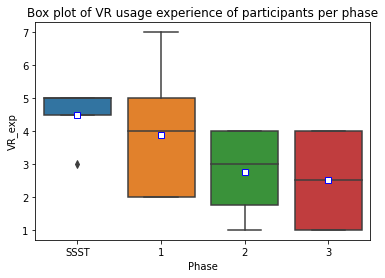


VR usage experience value_counts per group/phase
Phase  VR_exp
1      2         3
       4         2
       5         2
       7         1
2      4         3
       1         2
       3         2
       2         1
3      1         3
       4         3
       2         1
       3         1
SSST   5         3
       3         1
Name: VR_exp, dtype: int64


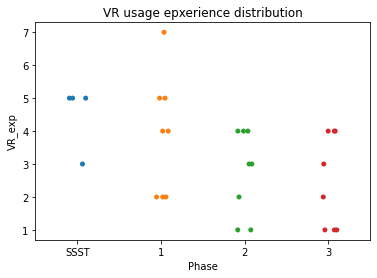

Mean Occupational stress of participants
Phase
1       5.625
2       5.750
3       5.125
SSST    5.000
Name: Occupation_stress, dtype: float64

Median Occupational stress of participants
Phase
1       5.5
2       6.0
3       6.0
SSST    5.0
Name: Occupation_stress, dtype: float64


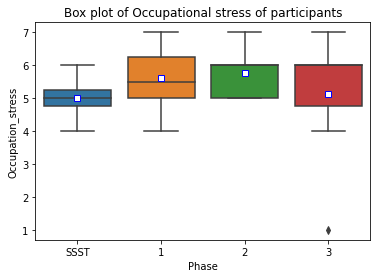


Occupational stress of participants value_counts per group/phase
Phase  Occupation_stress
1      5                    3
       6                    2
       7                    2
       4                    1
2      6                    4
       5                    3
       7                    1
3      6                    4
       1                    1
       4                    1
       5                    1
       7                    1
SSST   5                    2
       4                    1
       6                    1
Name: Occupation_stress, dtype: int64


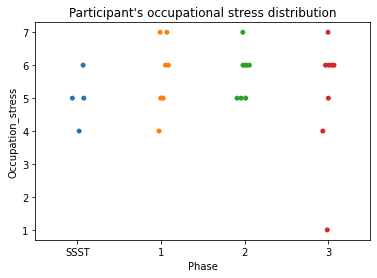

In [112]:
# 1 - 7 scale questions ('VR_exp', 'Occupation_stress') analysis

# VR usage experience

print("Mean VR usage experience of participants per group/phase")
print(df_grouped['VR_exp'].mean())

print("\nMedian VR usage experience of participants per group/phase")
print(df_grouped['VR_exp'].median())

sns_plot = sns.boxplot(x=df['Phase'],
            y=df['VR_exp'],
            showmeans=True,
            meanprops={"marker": "s", "markerfacecolor": "white", "markeredgecolor": "blue"}).set_title(
                'Box plot of VR usage experience of participants per phase')
plt.show()
fig = sns_plot.get_figure()
fig.savefig(demo_directory_path +
            "Box_plot_VR_usage_exp_per_phase.png")


print("\nVR usage experience value_counts per group/phase")
print(df_grouped['VR_exp'].value_counts())

sns_plot = sns.stripplot(x=df['Phase'], y=df['VR_exp']).set_title(
    "VR usage epxerience distribution")
plt.show()
fig = sns_plot.get_figure()
fig.savefig(demo_directory_path +
            "VR_usage_exp_distribution.png")


# Occupation_stress

print("Mean Occupational stress of participants")
print(df_grouped['Occupation_stress'].mean())

print("\nMedian Occupational stress of participants")
print(df_grouped['Occupation_stress'].median())

sns_plot = sns.boxplot(x=df['Phase'],
            y=df['Occupation_stress'],
            showmeans=True,
            meanprops={"marker": "s", "markerfacecolor": "white", "markeredgecolor": "blue"}).set_title(
                'Box plot of Occupational stress of participants')
plt.show()
fig = sns_plot.get_figure()
fig.savefig(demo_directory_path +
            "Box_plot_occupational_stress_per_phase.png")


print("\nOccupational stress of participants value_counts per group/phase")
print(df_grouped['Occupation_stress'].value_counts())

sns_plot = sns.stripplot(x=df['Phase'], y=df['Occupation_stress']).set_title(
    "Participant's occupational stress distribution")
plt.show()
fig = sns_plot.get_figure()
fig.savefig(demo_directory_path +
            "Occupational_stress_distribution.png")


# Processing SAM Questionnaires

All three data frames will be processed together <br/>
'ID', 'Arousal_rating', 'Pleasure_rating', 'Phase' are the new column names of these data frames.

In [113]:
# Adding a new column to each SAM dataframe that indicates the type of SAM questionnaire, users filled after a session.

for i, df in enumerate(df_list[3:]):
    if i == 0:
        df['Session'] = "Baseline"
    elif i == 1:
        df['Session'] = "Stress_test"
    else:
        df['Session'] = "Relaxation_task"

# Combining all the SAM dataframes

combined_df = pd.concat(df_list[3:])

In [114]:
# Stats of SAM questionnaire's

print("Arousal dimension user ratings stats: \n")
print(combined_df.groupby(['Session', 'Phase'])[
      'Arousal_rating'].describe())
print("\n\nPleasure dimension user ratings stats: \n")
print(combined_df.groupby(['Session', 'Phase'])[
      'Pleasure_rating'].describe())


Arousal dimension user ratings stats: 

                       count   mean       std  min   25%  50%   75%  max
Session         Phase                                                   
Baseline        1        8.0  1.750  0.707107  1.0  1.00  2.0  2.00  3.0
                2        8.0  1.750  0.886405  1.0  1.00  1.5  2.25  3.0
                3        8.0  1.875  0.640870  1.0  1.75  2.0  2.00  3.0
                SSST     4.0  2.250  0.957427  1.0  1.75  2.5  3.00  3.0
Relaxation_task 2        8.0  1.250  0.462910  1.0  1.00  1.0  1.25  2.0
                3        8.0  1.250  0.707107  1.0  1.00  1.0  1.00  3.0
Stress_test     1        8.0  2.375  1.060660  1.0  1.75  2.5  3.00  4.0
                2        8.0  2.125  0.640870  1.0  2.00  2.0  2.25  3.0
                3        8.0  2.125  0.991031  1.0  1.75  2.0  2.25  4.0
                SSST     4.0  3.500  1.290994  2.0  2.75  3.5  4.25  5.0


Pleasure dimension user ratings stats: 

                       count   mean      

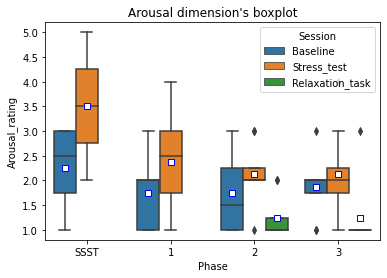

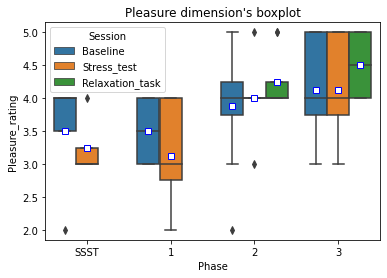

In [115]:
sns_plot = sns.boxplot(x=combined_df['Phase'],
            y=combined_df['Arousal_rating'],
            hue=combined_df['Session'],
            showmeans=True,
            meanprops={"marker": "s", "markerfacecolor": "white", "markeredgecolor": "blue"}).set_title('Arousal dimension\'s boxplot')
plt.show()
fig = sns_plot.get_figure()
fig.savefig(sam_directory_path +
            "Box_plot_arousal_dimension.png")


sns_plot = sns.boxplot(x=combined_df['Phase'],
            y=combined_df['Pleasure_rating'],
            hue=combined_df['Session'],
            showmeans=True,
            meanprops={"marker": "s", "markerfacecolor": "white", "markeredgecolor": "blue"}).set_title('Pleasure dimension\'s boxplot')
plt.show()
fig = sns_plot.get_figure()
fig.savefig(sam_directory_path +
            "Box_plot_pleasure_dimension.png")



Discrete distribution plot of the Arousal dimension



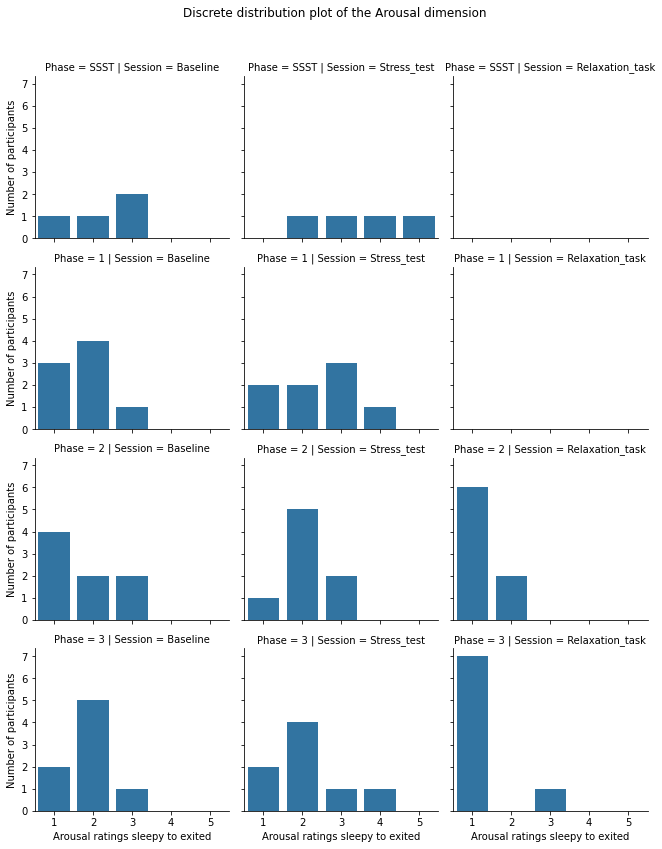

Discrete distribution plot of the Pleasure dimension



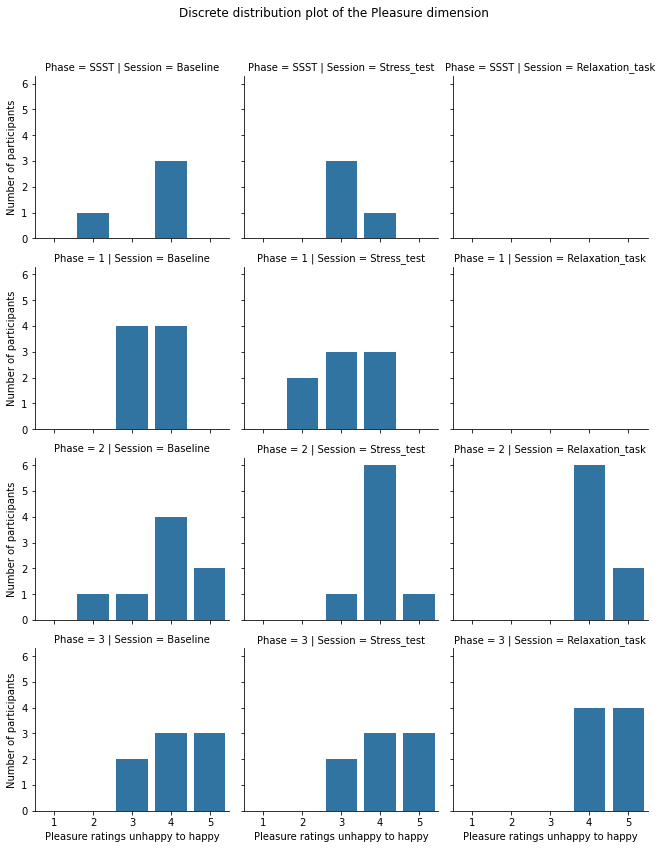

In [117]:
# Discrete distribution of SAM Questionnaire's answers for each phase and session

print("Discrete distribution plot of the Arousal dimension\n")
grid = sns.FacetGrid(combined_df, row='Phase', col='Session')
grid.map(sns.countplot, "Arousal_rating", order=[1, 2, 3, 4, 5])
grid.fig.suptitle("Discrete distribution plot of the Arousal dimension")
grid.fig.subplots_adjust(top=0.9)
grid.set_xlabels('Arousal ratings sleepy to exited')
grid.set_ylabels('Number of participants')
plt.show()
grid.savefig(sam_directory_path +
            "Discrete_distribution_plot_Arousal.png")

print("Discrete distribution plot of the Pleasure dimension\n")
grid = sns.FacetGrid(combined_df, row='Phase', col='Session')
grid.map(sns.countplot, "Pleasure_rating", order=[1, 2, 3, 4, 5])
grid.fig.suptitle("Discrete distribution plot of the Pleasure dimension")
grid.fig.subplots_adjust(top=0.9)
grid.set_xlabels('Pleasure ratings unhappy to happy')
grid.set_ylabels('Number of participants')
plt.show()
grid.savefig(sam_directory_path +
            "Discrete_distribution_plot_Pleasure.png")


In [118]:
x_df = combined_df.groupby(["Phase", "Session"]).mean().reindex(['Baseline', 'Stress_test', 'Relaxation_task'], level='Session').reset_index().drop(["ID", "Pleasure_rating"], 1)
y_df = combined_df.groupby(["Phase", "Session"]).mean().reindex(['Baseline', 'Stress_test', 'Relaxation_task'], level='Session').reset_index().drop(["ID", "Arousal_rating"], 1)

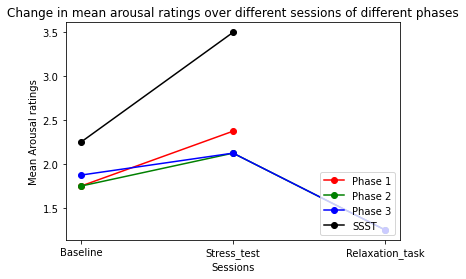

In [121]:
# Plot that compares means of each SAM questionnaire's answers

plt.plot(x_df[x_df['Phase'] == '1']['Session'],
         x_df[x_df['Phase'] == '1']['Arousal_rating'],
         marker='o',
         color='red',
         label="Phase 1")
plt.plot(x_df[x_df['Phase'] == '2']['Session'],
         x_df[x_df['Phase'] == '2']['Arousal_rating'],
         marker='o',
         color='green',
         label="Phase 2")
plt.plot(x_df[x_df['Phase'] == '3']['Session'],
         x_df[x_df['Phase'] == '3']['Arousal_rating'],
         marker='o',
         color='blue',
         label="Phase 3")
plt.plot(x_df[x_df['Phase'] == 'SSST']['Session'],
         x_df[x_df['Phase'] == 'SSST']['Arousal_rating'],
         marker='o',
         color='black',
         label="SSST")
plt.title(
    'Change in mean arousal ratings over different sessions of different phases')
plt.ylabel("Mean Arousal ratings")
plt.xlabel("Sessions")
plt.legend(loc='lower right')
fig = plt.figure(1)
fig.savefig(sam_directory_path +
            "Arousal_mean_ratings_per_phase_across_sessions.png")

plt.show()


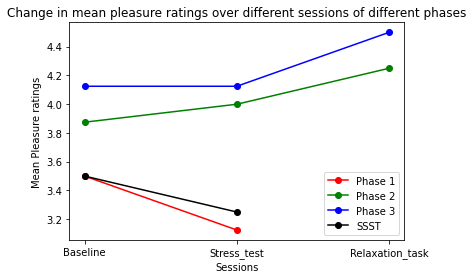

In [122]:
plt.plot(y_df[y_df['Phase'] == '1']['Session'],
         y_df[y_df['Phase'] == '1']['Pleasure_rating'],
         marker='o',
         color='red',
         label="Phase 1")
plt.plot(y_df[y_df['Phase'] == '2']['Session'],
         y_df[y_df['Phase'] == '2']['Pleasure_rating'],
         marker='o',
         color='green',
         label="Phase 2")
plt.plot(y_df[y_df['Phase'] == '3']['Session'],
         y_df[y_df['Phase'] == '3']['Pleasure_rating'],
         marker='o',
         color='blue',
         label="Phase 3")
plt.plot(y_df[y_df['Phase'] == 'SSST']['Session'],
         y_df[y_df['Phase'] == 'SSST']['Pleasure_rating'],
         marker='o',
         color='black',
         label="SSST")
plt.title(
    'Change in mean pleasure ratings over different sessions of different phases')
plt.ylabel("Mean Pleasure ratings")
plt.xlabel("Sessions")
plt.legend(loc='lower right')
fig = plt.figure(1)
fig.savefig(sam_directory_path +
            "Pleasure_mean_ratings_per_phase_across_sessions.png")
plt.show()


# Post study Questionnaire's analysis

Columns are ['ID', 'Involving', 'Relaxing', 'Recommendation', 'Rewarding', 'Fun', 'Relaxing_in_future', 
                      'Frustrating', 'Tiring', 'VR_Aesthetically_Pleasing', 'Phase'] for VR's questionnaire and <br/>['ID', 'Involving', 'Relaxing', 'Recommendation', 'Rewarding', 'Fun',
                      'Relaxing_in_future', 'Frustrating', 'Tiring', 'VR_Aesthetically_Pleasing',
                      'Haptic_soothing', 'Haptic_distracting', 'Haptic_linking_VR', 'Phase'] for VR+Haptics questionnaire

In [73]:
vr_df = df_list[1]
vr_haptics_df = df_list[2]

print("\nDescription of Post VR questionnaire's data:")
vr_df.describe().drop(['ID'], 1)



Description of Post VR questionnaire's data:


,Involving,Relaxing,Recommendation,Rewarding,Fun,Relaxing_in_future,Frustrating,Tiring,VR_Aesthetically_Pleasing
count,8.00000,8.00000,8.000000,8.000000,8.000000,8.00000,8.000000,8.000000,8.000000
mean,3.62500,4.12500,4.375000,3.625000,4.375000,3.75000,1.125000,2.000000,4.625000
std,1.06066,0.64087,0.517549,1.505941,0.744024,1.28174,0.353553,1.195229,0.517549
min,2.00000,3.00000,4.000000,1.000000,3.000000,2.00000,1.000000,1.000000,4.000000
25%,3.00000,4.00000,4.000000,2.750000,4.000000,2.75000,1.000000,1.000000,4.000000
50%,3.50000,4.00000,4.000000,4.000000,4.500000,4.00000,1.000000,1.500000,5.000000
75%,4.25000,4.25000,5.000000,5.000000,5.000000,5.00000,1.000000,3.000000,5.000000
max,5.00000,5.00000,5.000000,5.000000,5.000000,5.00000,2.000000,4.000000,5.000000


In [74]:
print("\nDescription of Post VR+Haptics questionnaire's data:")
vr_haptics_df.describe().drop(['ID'], 1)



Description of Post VR+Haptics questionnaire's data:


,Involving,Relaxing,Recommendation,Rewarding,Fun,Relaxing_in_future,Frustrating,Tiring,VR_Aesthetically_Pleasing,Haptic_soothing,Haptic_distracting,Haptic_linking_VR
count,8.000000,8.000000,8.00000,8.000000,8.000000,8.00000,8.00000,8.000000,8.000000,8.000000,8.000000,8.00000
mean,3.875000,4.375000,3.75000,4.125000,4.625000,3.62500,1.25000,1.625000,4.250000,4.375000,1.750000,4.00000
std,0.991031,0.744024,1.28174,0.834523,0.744024,1.30247,0.46291,0.744024,0.886405,0.517549,0.886405,0.92582
min,2.000000,3.000000,1.00000,3.000000,3.000000,1.00000,1.00000,1.000000,3.000000,4.000000,1.000000,2.00000
25%,3.750000,4.000000,3.75000,3.750000,4.750000,3.00000,1.00000,1.000000,3.750000,4.000000,1.000000,4.00000
50%,4.000000,4.500000,4.00000,4.000000,5.000000,4.00000,1.00000,1.500000,4.500000,4.000000,1.500000,4.00000
75%,4.250000,5.000000,4.25000,5.000000,5.000000,4.25000,1.25000,2.000000,5.000000,5.000000,2.250000,4.25000
max,5.000000,5.000000,5.00000,5.000000,5.000000,5.00000,2.00000,3.000000,5.000000,5.000000,3.000000,5.00000


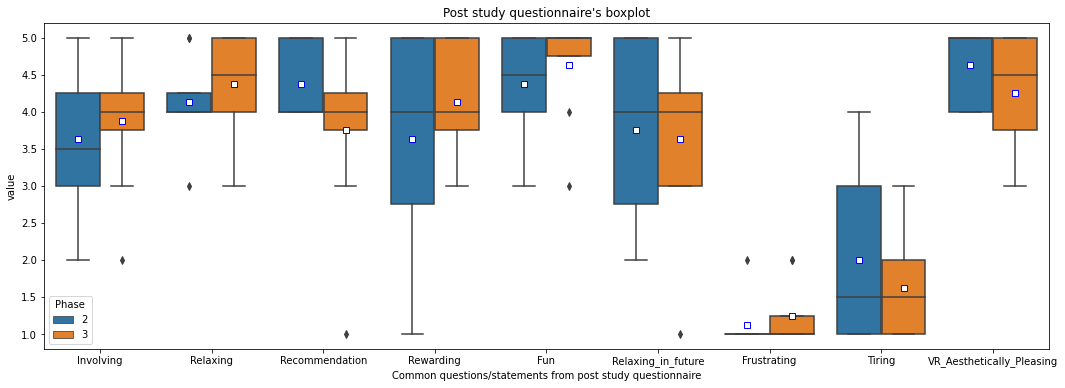

In [124]:
# Box plots comparing 2nd and 3rd phase's questionnaire results

combined_post_df = pd.concat([vr_df, vr_haptics_df])
melted_df = combined_post_df[combined_post_df.columns[1:11]].melt(id_vars=[
                                                                  'Phase'])
plt.figure(figsize=(18, 6))
sns_plot = sns.boxplot(x = melted_df['variable'], 
            y = melted_df['value'], 
            hue = melted_df['Phase'],
            showmeans=True, 
            meanprops={"marker": "s", "markerfacecolor": "white", "markeredgecolor": "blue"}).set_title('Post study questionnaire\'s boxplot')
plt.xlabel('Common questions/statements from post study questionnaire')
plt.show()
fig = sns_plot.get_figure()
fig.savefig(post_study_directory_path +
            "Box_plot_common_questions_phase_2_and_3.png")


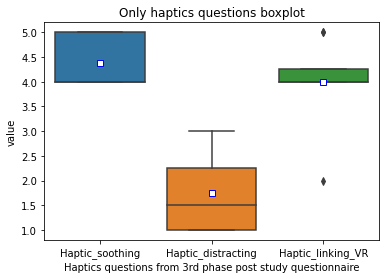

In [125]:
# Box plot of only haptics' related questions from the 3rd phase's post study questionnaire

melted_vr_haptics_df = vr_haptics_df[vr_haptics_df.columns[10:13]].melt()
sns_plot = sns.boxplot(x = melted_vr_haptics_df['variable'], 
            y = melted_vr_haptics_df['value'],
            showmeans=True,
            meanprops={"marker": "s", "markerfacecolor": "white", "markeredgecolor": "blue"}).set_title('Only haptics questions boxplot')
plt.xlabel('Haptics questions from 3rd phase post study questionnaire')
plt.show()
fig = sns_plot.get_figure()
fig.savefig(post_study_directory_path +
            "Box_plot_haptics_questions.png")


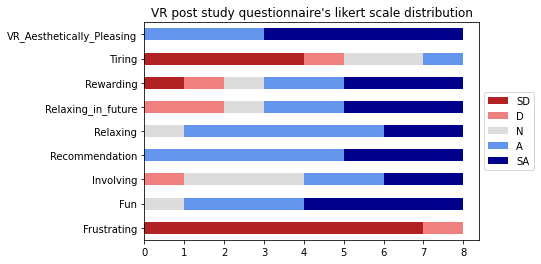

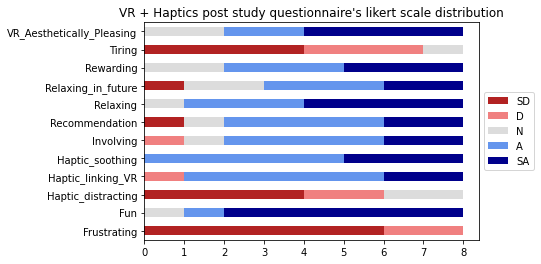

In [126]:
# Stacked bar graphs of VR questionnaire

# Preprocessing the vr_df

vr_df_processed = pd.DataFrame(vr_df[vr_df.columns[1:10]].melt().value_counts().reset_index())
vr_df_processed.columns = ['Variable', 'Value', 'Count']
vr_df_processed = vr_df_processed.pivot(index='Variable', 
                                        columns='Value',
                                        values='Count').reset_index().fillna(0)
vr_df_processed.columns = ['Question', 'SD', 'D', 'N', 'A', 'SA']
vr_df_processed.set_index('Question', inplace=True)
vr_df_processed.index.name = None
vr_df_processed = vr_df_processed.astype('int64')

# Preprocessing the vr_haptics_df

vr_haptics_df_processed = pd.DataFrame(
    vr_haptics_df[vr_haptics_df.columns[1:13]].melt().value_counts().reset_index())
vr_haptics_df_processed.columns = ['Variable', 'Value', 'Count']
vr_haptics_df_processed = vr_haptics_df_processed.pivot(index='Variable',
                                                        columns='Value',
                                                        values='Count').reset_index().fillna(0)
vr_haptics_df_processed.columns = ['Question', 'SD', 'D', 'N', 'A', 'SA']
vr_haptics_df_processed.set_index('Question', inplace=True)
vr_haptics_df_processed.index.name = None
vr_haptics_df_processed = vr_haptics_df_processed.astype('int64')

# Plotting the stacked bar plots

likert_colors = ['firebrick', 'lightcoral',
                'gainsboro', 'cornflowerblue', 'darkblue']
                
vr_df_processed.plot.barh(stacked=True, color=likert_colors,
                          edgecolor=None, legend=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("VR post study questionnaire\'s likert scale distribution")
fig = plt.figure(1)
fig.savefig(post_study_directory_path +
            "VR_questionnaire_distribution.png")
plt.show()

vr_haptics_df_processed.plot.barh(stacked=True, color=likert_colors,
                                edgecolor=None, legend=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("VR + Haptics post study questionnaire\'s likert scale distribution")
fig = plt.figure(1)
fig.savefig(post_study_directory_path +
            "VR_haptics_questionnaire_distribution.png")
plt.show()
